IMDB to Amazon product review

In [3]:
# Importing essential libraries and functions
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [6]:
movie_reviews = pd.read_csv("dataset/IMDB Dataset.csv")

In [9]:
movie_reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [11]:
# Function remove_tags to handles HTML tags
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''
    return TAG_RE.sub('', text) 

# Function preprocess_text to clean up reviews
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    sentence = sen.lower()
    # Remove html tags
    sentence = remove_tags(sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
#     # Remove Stopwords
#     pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
#     sentence = pattern.sub('', sentence)
    return sentence   

# Calling preprocessing_text function on movie_reviews
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

# Converting sentiment labels to 0 & 1
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [18]:
X_train = X
y_train = y

In [19]:
product_reviews = pd.read_csv("dataset/test.csv") 

In [20]:
product_reviews

,class_index,review_title,review_text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
...,...,...,...
399995,1,Unbelievable- In a Bad Way,We bought this Thomas for our son who is a hug...
399996,1,"Almost Great, Until it Broke...",My son recieved this as a birthday gift 2 mont...
399997,1,Disappointed !!!,"I bought this toy for my son who loves the ""Th..."
399998,2,Classic Jessica Mitford,This is a compilation of a wide range of Mitfo...


In [21]:
# product_reviews['class_index'] = product_reviews['class_index'].replace({1: 0, 2: 1})

In [22]:
product_reviews.drop('review_title', axis=1, inplace=True)

In [33]:
product_reviews = product_reviews[:20000]

In [34]:
product_reviews

,class_index,review_text
0,2,My lovely Pat has one of the GREAT voices of h...
1,2,Despite the fact that I have only played a sma...
2,1,I bought this charger in Jul 2003 and it worke...
3,2,Check out Maha Energy's website. Their Powerex...
4,2,Reviewed quite a bit of the combo players and ...
...,...,...
19995,1,I had not read any Stephen King and picked up ...
19996,1,This short (224 pages) novel begs the question...
19997,2,Ordinary people in extraordinary situations. T...
19998,2,My father pushed The Girl Who Loved Tom Gordon...


In [35]:
# Calling preprocessing_text function on product_reviews
X = []
sentences = list(product_reviews['review_text'])
for sen in sentences:
    X.append(preprocess_text(sen))

# Converting sentiment labels to 0 & 1
y_test = product_reviews['class_index']
y_test = np.array(list(map(lambda x: 1 if x==2 else 0, y_test)))

In [36]:
X_test = X

In [37]:
y_test

array([1, 1, 0, ..., 1, 1, 1])

In [38]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1

# Padding all reviews to fixed length 100
maxlen = 200
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [39]:
# Load GloVe word embeddings and create an Embeddings Dictionary
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open('glove.6B.200d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# Create Embedding Matrix having 200 columns 
# Containing 200-dimensional GloVe word embeddings for all words in our corpus.
embedding_matrix = zeros((vocab_length, 200))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Print Embedding Matrix shape
embedding_matrix.shape

(101399, 200)

In [40]:
from keras.layers import Conv1D

# Neural Network architecture
cnn_model = Sequential()
embedding_layer = Embedding(vocab_length, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

# Model compiling
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

# Model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

2023-12-14 13:27:47.619045: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          20279800  
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          128128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20408057 (77.85 MB)
Trainable params: 128257 (501.00 KB)
Non-trainable params: 20279800 (77.36 MB)
_________________________________________________________________
None
Epoch 1/6
313/313 [==============================] - 20s 57ms/step - l

625/625 [==============================] - 3s 5ms/step - loss: 0.5206 - acc: 0.7994
Test Score: 0.5206495523452759
Test Accuracy: 0.7993999719619751


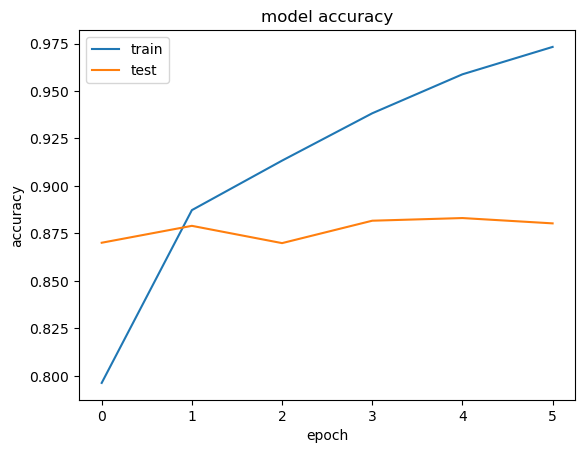

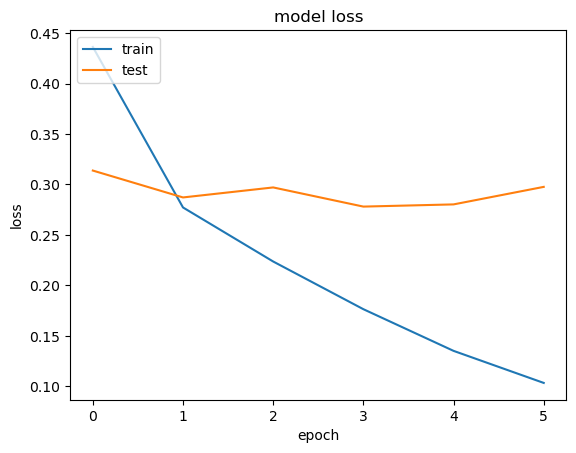

In [41]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# Model Performance Charts
import matplotlib.pyplot as plt
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [50]:
from sklearn.metrics import f1_score
# Predictions on the Test Set
y_pred = cnn_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute F1 score
f1 = f1_score(y_test, y_pred_binary)

print("F1 Score:", f1)

625/625 [==============================] - 3s 5ms/step
F1 Score: 0.8240350877192983
